##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 3.8MB 34.7MB/s 
     |████████████████████████████████| 450kB 54.3MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 2.0.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


# Image Classification using tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this Colab you will classify images of flowers. You will build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Packages

Let's start by importing required packages. **os** package is used to read files and directory structure, **numpy** is used to convert python list to numpy array and to perform required matrix operations and **matplotlib.pyplot** is used to plot the graph and display images in our training and validation data.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

### TODO: Import TensorFlow and Keras Layers

In the cell below, import Tensorflow and the Keras layers and models you will use to build your CNN. Also, import the `ImageDataGenerator` from Keras so that you can perform image augmentation.

In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

After downloading the dataset, we need to extract its contents.

In [ ]:
base_dir = r"/content/drive/My Drive/Competitions/Grade 10/Stroke Project/Facial Droop Database"
train_dir = r"/content/drive/My Drive/Competitions/Grade 10/Stroke Project/Facial Droop Database/train"
val_dir = r"/content/drive/My Drive/Competitions/Grade 10/Stroke Project/Facial Droop Database/val"

train_s = r"/content/drive/My Drive/Competitions/Grade 10/Stroke Project/Facial Droop Database/train/Stroke"
train_ns = r"/content/drive/My Drive/Competitions/Grade 10/Stroke Project/Facial Droop Database/train/No Stroke"

val_s = r"/content/drive/My Drive/Competitions/Grade 10/Stroke Project/Facial Droop Database/val/Stroke"
val_ns = r"/content/drive/My Drive/Competitions/Grade 10/Stroke Project/Facial Droop Database/val/No Stroke"

In [ ]:
num_train_ns = len(os.listdir(train_ns))
num_train_s = len(os.listdir(train_s))

num_val_ns = len(os.listdir(val_ns))
num_val_s = len(os.listdir(val_s))

num_train = num_train_ns + num_train_s
num_val = num_val_ns + num_val_s

print('total training stroke images:', num_train_s)
print('total training no stroke images:', num_train_ns)

print('total val stroke images:', num_val_s)
print('total val no stroke images:', num_val_ns)
print("--")
print("Total training images:", num_train)
print("Total val images:", num_val)

total training stroke images: 724
total training no stroke images: 480
total val stroke images: 147
total val no stroke images: 120
--
Total training images: 1204
Total val images: 267


In [ ]:
BATCH_SIZE = 100
IMG_SHAPE = 220

In [ ]:
classes = ['Stroke', 'No Stroke']

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process. 

### TODO: Put It All Together

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15

Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, to shuffle the images, and to set the class mode to `sparse`.

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 1204 images belonging to 2 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset. 

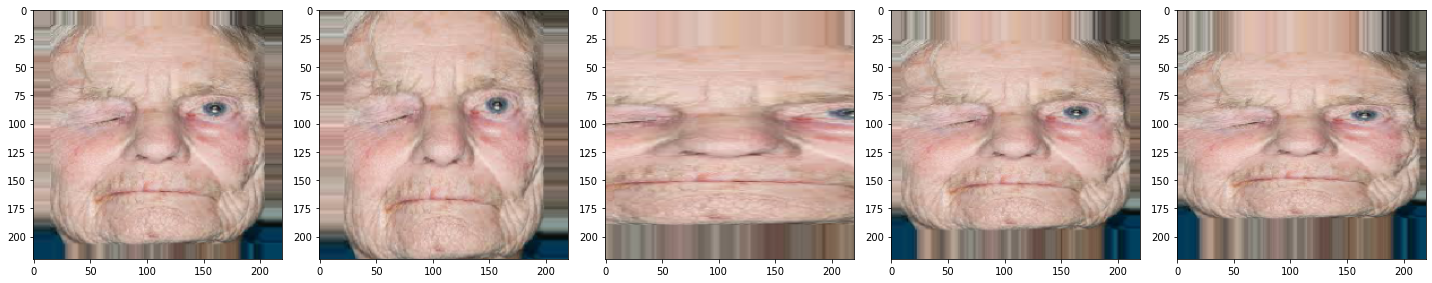

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Create a Data Generator for the Validation Set

Generally, we only apply data augmentation to our training examples. So, in the cell below, use ImageDataGenerator to create a transformation that only rescales the images by 255. Then use the `.flow_from_directory` method to apply the above transformation to the images in our validation set. Make sure you indicate the batch size, the path to the directory of the validation images, the target size for the images, and to set the class mode to `sparse`. Remember that it is not necessary to shuffle the images in the validation set. 

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 267 images belonging to 2 classes.


# TODO: Create the CNN

In the cell below, create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a `Conv2D` layer followed by a max pool layer. The first convolutional block should have 16 filters, the second one should have 32 filters, and the third one should have 64 filters. All convolutional filters should be 3 x 3. All max pool layers should have a `pool_size` of `(2, 2)`.

After the 3 convolutional blocks you should have a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 5 classes which is done by the **softmax** activation function. All other layers should use a **relu** activation function. You should also add Dropout layers with a probability of 20%, where appropriate.

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dropout(0.2),
    Dense(512, activation='relu'),

    Dropout(0.2),
    Dense(256, activation='relu'),

    Dropout(0.2),
    Dense(2),
])

# TODO: Compile the Model

In the cell below, compile your model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so make sure you also pass the metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       7

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# TODO: Train the Model

In the cell below, train your model using the **fit_generator** function instead of the usual **fit** function. We have to use the `fit_generator` function because we are using the **ImageDataGenerator** class to generate batches of training and validation data for our model. Train the model for 80 epochs and make sure you use the proper parameters in the `fit_generator` function.

In [ ]:
epochs = 100

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))),
    callbacks=[early_stopping, model_checkpoint]
)

Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 120s 9s/step - loss: 0.8468 - accuracy: 0.6130 - val_loss: 1.0587 - val_accuracy: 0.4494
Epoch 2/100
13/13 [==============================] - 81s 6s/step - loss: 0.6153 - accuracy: 0.6711 - val_loss: 0.5939 - val_accuracy: 0.6517
Epoch 3/100
13/13 [==============================] - 81s 6s/step - loss: 0.5370 - accuracy: 0.7367 - val_loss: 0.5479 - val_accuracy: 0.7341
Epoch 4/100
13/13 [==============================] - 80s 6s/step - loss: 0.5418 - accuracy: 0.7591 - val_loss: 0.5515 - val_accuracy: 0.7228
Epoch 5/100
13/13 [==============================] - 80s 6s/step - loss: 0.5133 - accuracy: 0.7384 - val_loss: 0.5550 - val_accuracy: 0.7266
Epoch 6/100
13/13 [==============================] - 79s 6s/step - loss: 0.5008 - accuracy: 0.7641 - val_loss: 0.5163 - val_accuracy: 0.7191
Epoch 7/100
13/13 [==============================] - 79s 6s/step - loss: 0.4887 - accuracy: 0.7691 - val_loss: 0

# TODO: Plot Training and Validation Graphs.

In the cell below, plot the training and validation accuracy/loss graphs.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(27)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [ ]:
loaded = tf.saved_model.load(export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [ ]:
labels = ['No Stroke', 'Stroke']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

try:
  from google.colab import files
  files.download('converted_model.tflite')
  files.download('labels.txt')
except:
  pass

In [ ]:
import cv2
n = 5
for i in os.listdir(test_s)
    if i >= n:
        test_images = cv2.imread(i)
        test_labels = np.asarray([["Stroke")
        predictions = model.predict(test_images)
    else:
        break

In [ ]:
for i in os.listdir(test_ns)
    if i >= n:
        test_images = cv2.imread(i)
        test_labels = np.asarray([["No Stroke")
        predictions = model.predict(test_images)
    else:
        break

In [ ]:
predictions.shape

In [ ]:
predictions[0]

In [ ]:
np.argmax(predictions[0])

In [ ]:
test_labels[0]

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [ ]:
np.argmax(predictions_single[0])

In [ ]:
print(model.predict(r"D:\Downloads\Webp.net-resizeimage (1).jpg"))
print(model.predict(r"D:\Downloads\Webp.net-resizeimage.jpg"))